# Промышленность 

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;

- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);

- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);

- `data_gas.csv` — данные о продувке сплава газом;

- `data_temp.csv` — результаты измерения температуры;

- `data_wire.csv` — данные о проволочных материалах (объём);

- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## План работы(приблизительный)

1. Первичный анализ данных. Определение номеров партий, в которых производились замеры температур, вычлинение именно этих данных из всей массы. 

2. Подготовка непосредственно признаков для дальнейшего моделирование. Объединение данных в единую таблицу, определение целевого признака - итоговая температура(последняя в партии). Генерация новых признаков в конечной таблице для моделирования. Определение тестовойвыборки(20%)

3. Использование нескольких моделей и выбрать наиболее эффективную, проперить на тестовой выборке. 

4. Провести итоговый анализ полученных результатов и составление общего вывода.

5. Составление отчета по всей работе, цель отчёта: "Взяв отчёт в руки – каждый сможет понять и реализовать полученную модель без доп.исследований" 

## Первичный анализ данных

In [1]:
#импорты, используемых в работе, бибилиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import math
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')





In [2]:
da = pd.read_csv('/datasets/final_steel/data_arc.csv')
db = pd.read_csv('/datasets/final_steel/data_bulk.csv')
dg = pd.read_csv('/datasets/final_steel/data_gas.csv')
dt = pd.read_csv('/datasets/final_steel/data_temp.csv')
dw = pd.read_csv('/datasets/final_steel/data_wire.csv')

Данные выгрузила, но не все. Таблицу data_bulk_time.csv и data_wire_time.csv не использую, ввиду их нелеквидности. Теперь посмотрю основную и статистическую инвормацию по таблицам, количество пропусков, а также количество явных дубликатов.

In [3]:
#создам функцию для вывода основной информации для датасетов, чтобыв не повторять рутинные действия с каждой таблицей

def data_info(data):
    print('**Основная информация**')
    display(data.info())
    print('________________________________________________________________________________')
    print('**Статистическая информация по таблице**')
    display(data.describe())
    print('________________________________________________________________________________')
    print('**Количесво дубликатов в таблице**')
    display(data.duplicated().sum())
    print('________________________________________________________________________________')
    print('**Количество пропущенных значений таблицы**')
    display(data.isnull().sum())

### данные об электродах

In [4]:
data_info(da)

**Основная информация**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

________________________________________________________________________________
**Статистическая информация по таблице**


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


________________________________________________________________________________
**Количесво дубликатов в таблице**


0

________________________________________________________________________________
**Количество пропущенных значений таблицы**


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Пропусков и дубликатов нет, но в двух столбцах нужно исправить тип данных двух столбцов.

In [5]:
da['Начало нагрева дугой'] = pd.to_datetime(da['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
da['Конец нагрева дугой'] = pd.to_datetime(da['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

In [6]:
#Количество уникальных значений партии
len((da['key']).unique())

3214

<AxesSubplot:>

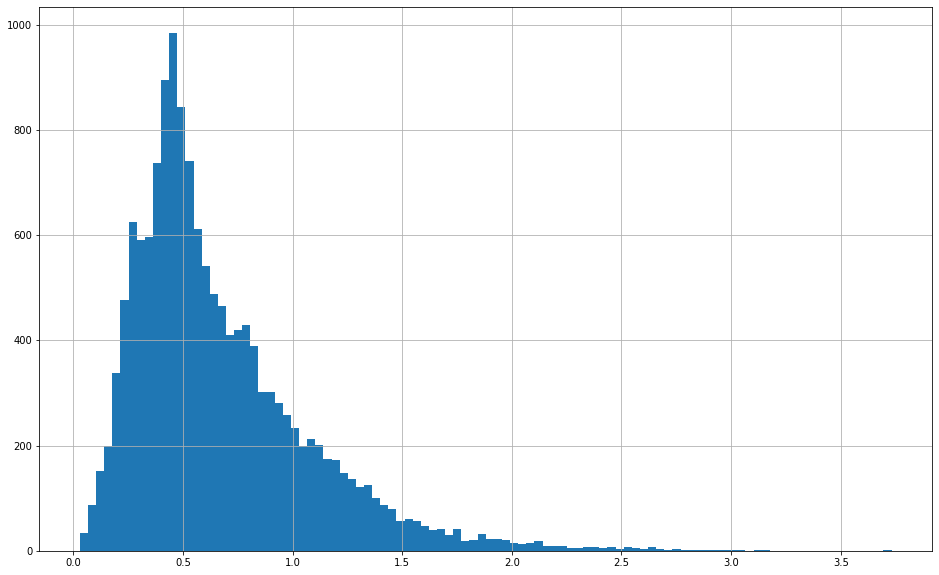

In [7]:
da['Активная мощность'].hist(bins=100, figsize=(16,10))

<AxesSubplot:>

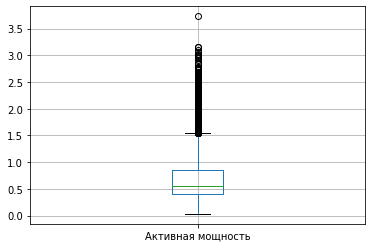

In [8]:
da.boxplot('Активная мощность')

Данные распределены нормально, со смещением влево, по графику с усами имеются выбросы, но их трогать не буду

<AxesSubplot:>

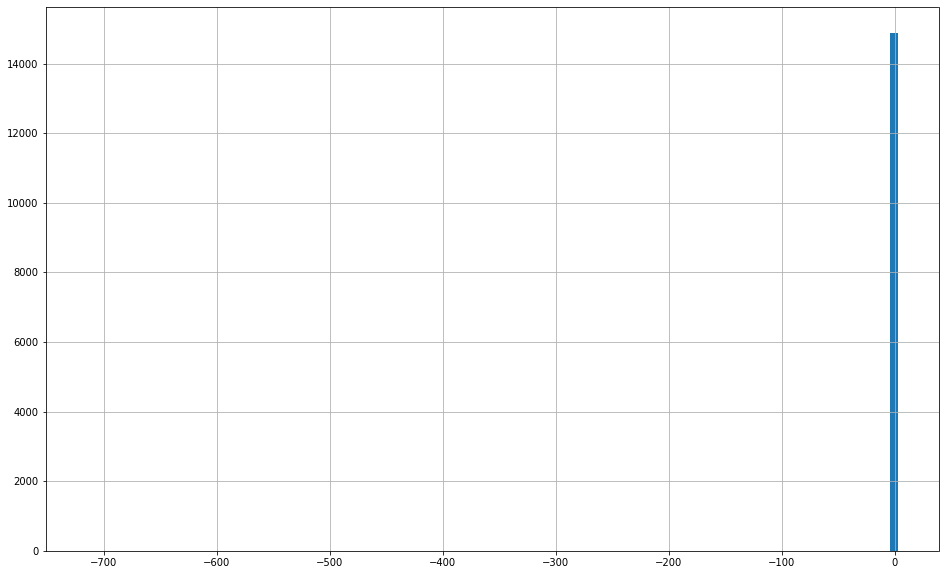

In [9]:
da['Реактивная мощность'].hist(bins=100, figsize=(16,10))

<AxesSubplot:>

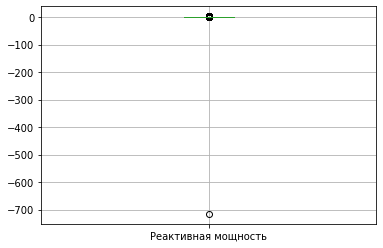

In [10]:
da.boxplot('Реактивная мощность')

Тут тоже имеются выбросы, ниже 0, видимо ошибка оборудования, либо же выгрузка данных или человеческий фактор. И эта ошибка явно мешает. Лучше удалить всю партию. Т.к. последяя строка - целевая будет.. и мы подставим потом не последнюю температуру по пратии, получается..

In [11]:
da[da['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Номер партии - 2116

In [12]:
da = da[da['key'] != 2116]
da.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   Начало нагрева дугой  14872 non-null  datetime64[ns]
 2   Конец нагрева дугой   14872 non-null  datetime64[ns]
 3   Активная мощность     14872 non-null  float64       
 4   Реактивная мощность   14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.1 KB


<AxesSubplot:>

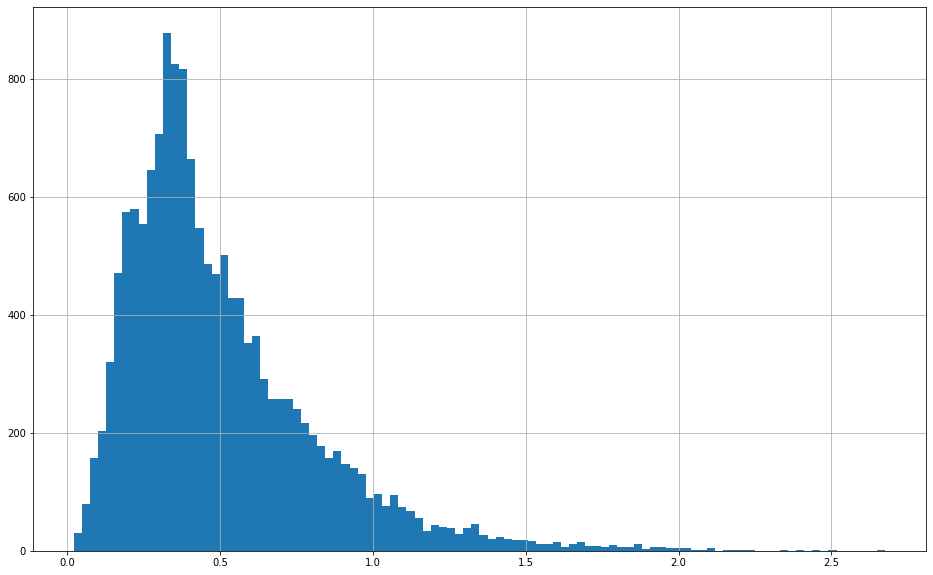

In [13]:
da['Реактивная мощность'].hist(bins=100, figsize=(16,10))

<AxesSubplot:>

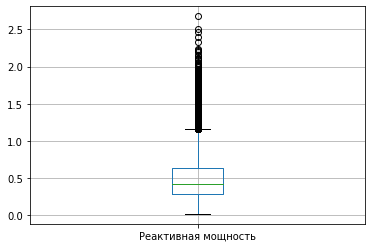

In [14]:
da.boxplot('Реактивная мощность')

График распределен нормально, со смещением влево, выбросы,в виде отрицательных значений, исключены.

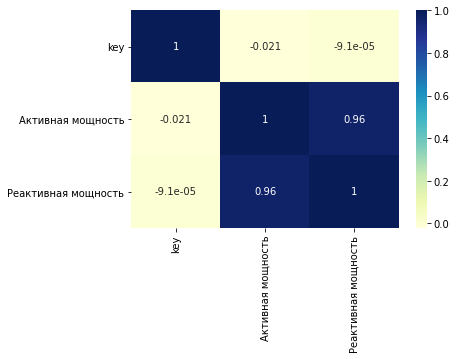

In [15]:
 
da_plot = sns.heatmap(da.corr(), cmap="YlGnBu", annot=True)  
    

plt.show()


Корреляция между активом и реакивом близка к единицы - модель может переобучиться, чтобы этого не произошло, создам новый признак - полная мощность (корень из сумм квадратов активной и реактивной мощностей)

### данные о подаче сыпучих материалов

In [16]:
data_info(db)

**Основная информация**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

________________________________________________________________________________
**Статистическая информация по таблице**


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


________________________________________________________________________________
**Количесво дубликатов в таблице**


0

________________________________________________________________________________
**Количество пропущенных значений таблицы**


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Дубликатов нет, очень много пропусков, но они объясняются этапностью, то есть на разном этапе добавляется разное количество сыпучих материалов, чтобы пропуски не мешали дальнейшему обучению модели, заменю их на 0. Тип данных в порядке.

In [17]:
db = db.fillna(0)
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


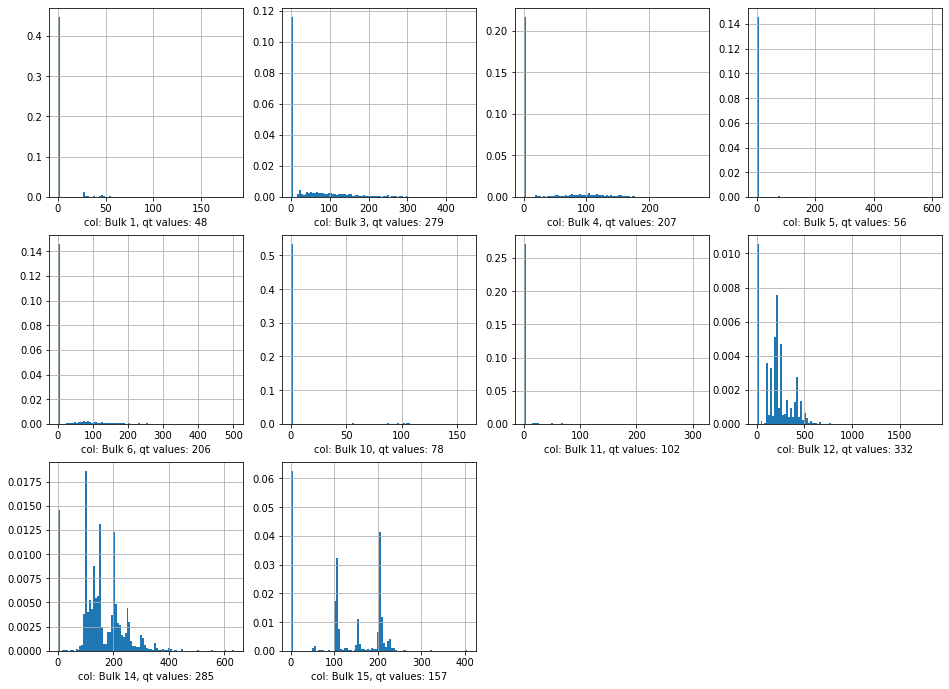

In [18]:
MIN_QT_UNIQUE = 30
fig = plt.figure()
nmb = 0
for i in range(1, 16):
    col = 'Bulk ' + str(i)
    val_cnt = len(db[col].unique())
    if  val_cnt < MIN_QT_UNIQUE:
        continue
    nmb += 1
    plt.subplot(4, 4, nmb)
    db[col].hist(bins=90, figsize=(16,16), density=True)
    plt.xlabel(f'col: {col}, qt values: {val_cnt}')


Cудить о графиках распределения добавок довольно сложно, так как имеются пропуски и "выбросы" так как где то вещество добавлялось, где то нет, да и в разных объемах. 

### данные о продувке сплава газом

In [19]:
data_info(dg)

**Основная информация**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

________________________________________________________________________________
**Статистическая информация по таблице**


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


________________________________________________________________________________
**Количесво дубликатов в таблице**


0

________________________________________________________________________________
**Количество пропущенных значений таблицы**


key      0
Газ 1    0
dtype: int64

Пропусков нет, дубликатов нет, тип данных в порядке. Посмотрю распределение и отклонения

<AxesSubplot:>

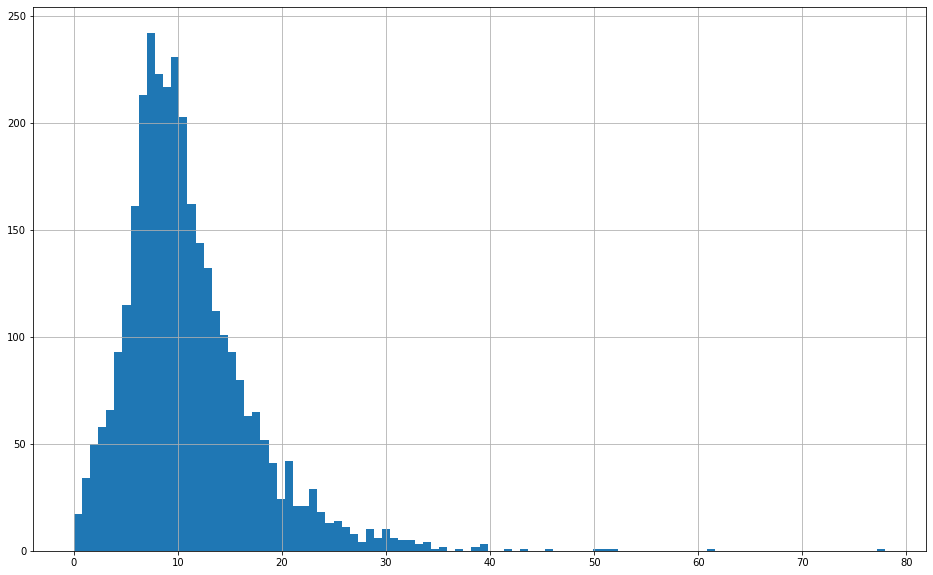

In [20]:
dg['Газ 1'].hist(bins=100, figsize=(16,10))


<AxesSubplot:>

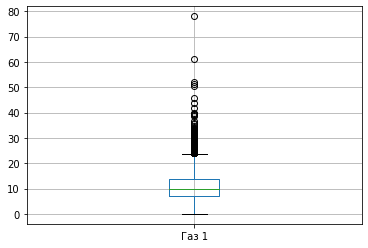

In [21]:
dg.boxplot('Газ 1')

График распределен нормально, со смещением влево. 

### результаты измерения температуры

In [22]:
data_info(dt)

**Основная информация**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

________________________________________________________________________________
**Статистическая информация по таблице**


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


________________________________________________________________________________
**Количесво дубликатов в таблице**


0

________________________________________________________________________________
**Количество пропущенных значений таблицы**


key                0
Время замера       0
Температура     2901
dtype: int64

Нужно исправить тип данных во времени замера, дубликатов нет, имеются пропуски которые удалю(по результату консультации поняла, что пропуски заполнить иначе не получится, так как они зависят от времени и материала сплава)

In [23]:
#Приведем типы данных в нужный формат
dt['Время замера'] = pd.to_datetime(dt['Время замера'], format='%Y-%m-%dT%H:%M:%S')

In [24]:
#Удаление пропущенных значений
dt.dropna().reset_index(drop = True)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
13001,3237,2019-08-31 22:44:04,1569.0
13002,3238,2019-08-31 23:30:31,1584.0
13003,3239,2019-09-01 01:31:47,1598.0
13004,3240,2019-09-01 02:39:01,1617.0


### данные о проволочных материалах

In [25]:
data_info(dw)

**Основная информация**
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

________________________________________________________________________________
**Статистическая информация по таблице**


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


________________________________________________________________________________
**Количесво дубликатов в таблице**


0

________________________________________________________________________________
**Количество пропущенных значений таблицы**


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Дубликатов нет, типы данных верные. Большое количество пропусков обуславливается зависимостью от конкретных партий, заменю отстутствующие значения на 0.

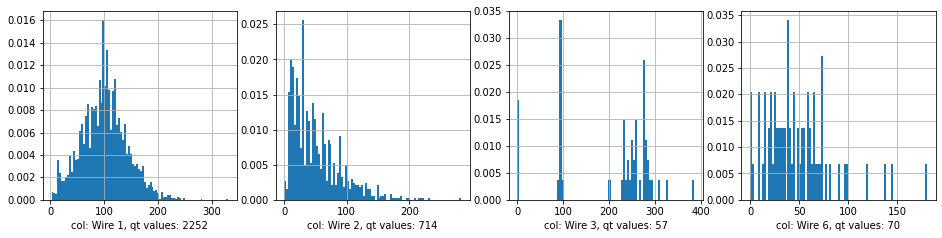

In [26]:
MIN_QT_UNIQUE = 30
fig = plt.figure()
nmb = 0
for i in range(1, 10):
    col = 'Wire ' + str(i)
    val_cnt = len(dw[col].unique())
    if  val_cnt < MIN_QT_UNIQUE:
        continue
    nmb += 1
    plt.subplot(4, 4, nmb)
    dw[col].hist(bins=90, figsize=(16,16), density=True)
    plt.xlabel(f'col: {col}, qt values: {val_cnt}')

In [27]:
dw = dw.fillna(0)
dw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


### Общий вывод по предобработке

 В данных в принципе нормальное распределены. Имелись пропуски в отстутсвующих значениях, а также в столбцах с указанием даты были не те типы. Выбросы, из ряда вон выходящие, имелись только в одном месте и были устранены. 
 Следующим этапом таблицы нужно будет объединить в одну, для дальнецшего моделирования, а также создать новые признаки(новый признак: полная мощность - корень из сумм квадратов активной и реактивной мощностей;
новый признак: время нагрева, когда электроды были активны;
новый признак: полная масса всех присадок;
новый признак: первая температура;) Дополнительных вопросов для себя пока не выявила.

## Подготовка данных к моделированию

В данном этапе нужно создать новые признакми, а также объединить данные в одну таблицу. Поделить признаки на целевой и обущающие.


In [28]:
#начну с полной мощности
def full_power(row):
        
    full_power = math.sqrt(row['Активная мощность']**2 + row['Реактивная мощность']**2)
    return full_power

In [29]:
da['Полная мощность'] = da.apply(full_power, axis=1)
da

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489


In [30]:
#количество итераций нагрева
da_count = da.groupby(by = 'key', as_index = False).count()[['key','Начало нагрева дугой']]
da_count.columns = ['key','Количество итераций в каждой партии']


In [31]:
#группировка по партиям
da = da.groupby(by = 'key', as_index = False).sum()
da = da.merge(da_count, how='left', on = 'key')
da

,key,Активная мощность,Реактивная мощность,Полная мощность,Количество итераций в каждой партии
0,1,4.878147,3.183241,5.826395,5
1,2,3.052598,1.998112,3.649216,4
2,3,2.525882,1.599076,2.989534,5
3,4,3.209250,2.060298,3.814962,4
4,5,3.347173,2.252643,4.035758,4
...,...,...,...,...,...
3208,3237,3.932467,2.828459,4.844982,5
3209,3238,2.106529,1.681182,2.696542,3
3210,3239,4.666754,3.111617,5.611883,8
3211,3240,2.984083,2.483267,3.891856,5


Активная и реактивная мощность для конечного моделирования не нужны.

In [32]:
da = da.drop(columns = ['Активная мощность', 'Реактивная мощность'], axis = 1)
da

,key,Полная мощность,Количество итераций в каждой партии
0,1,5.826395,5
1,2,3.649216,4
2,3,2.989534,5
3,4,3.814962,4
4,5,4.035758,4
...,...,...,...
3208,3237,4.844982,5
3209,3238,2.696542,3
3210,3239,5.611883,8
3211,3240,3.891856,5


Отсортирую значения по времени замера в таблице температуры

In [33]:
dt = dt.sort_values(by=['Время замера'])
dt

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


объединю по количеству времени замера и удалю партии, где меньше 2х замеров, то есть равно единице

In [34]:
count = dt.groupby(by = 'key', as_index=False).count()
one = count[count['Температура'] == 1]['key'].tolist()
dt = dt.query('key not in @one')
dt


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


In [35]:
#группировка по первым и последним значениям(промежуточные не нужны)
dt = dt.groupby(by ='key').agg(['first', 'last']).reset_index()
dt.columns = dt.columns.droplevel()
dt.columns = ['key', 'Время замера 1', 'Время замера 2','Температура 1','Температура 2']
#dt = dt[['key','Температура 1','Температура 2']]
dt

,key,Время замера 1,Время замера 2,Температура 1,Температура 2
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0
...,...,...,...,...,...
2470,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0
2471,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0
2472,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0
2473,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0


In [36]:
#объединение в одну таблицу
df_new = (dt.merge(da, how='left', on = 'key').merge(dw, how='inner', on = 'key').merge(db, how='inner', on = 'key').merge(dg, how='inner', on = 'key'))
df_new.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   key                                  2329 non-null   int64         
 1   Время замера 1                       2329 non-null   datetime64[ns]
 2   Время замера 2                       2329 non-null   datetime64[ns]
 3   Температура 1                        2329 non-null   float64       
 4   Температура 2                        2329 non-null   float64       
 5   Полная мощность                      2328 non-null   float64       
 6   Количество итераций в каждой партии  2328 non-null   float64       
 7   Wire 1                               2329 non-null   float64       
 8   Wire 2                               2329 non-null   float64       
 9   Wire 3                               2329 non-null   float64       
 10  Wire 4      

создам новый признак с полной массой всех сыпучих компонентов

In [42]:
#df_new = df_new.drop(columns = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15'], axis = 1)
df_new



,key,Время замера 1,Время замера 2,Температура 1,Температура 2,Полная мощность,Количество итераций в каждой партии,Wire 1,Wire 2,Wire 3,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,5.826395,5.0,60.059998,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,3.649216,4.0,96.052315,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,2.989534,5.0,91.160157,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,3.814962,4.0,89.063515,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,4.035758,4.0,89.238236,9.11456,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0,3.986869,4.0,89.150879,0.00000,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2325,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0,5.057033,6.0,114.179527,0.00000,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2326,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0,2.885017,3.0,94.086723,9.04800,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2327,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0,4.143749,5.0,118.110717,0.00000,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


Новый признак - время

In [43]:
df_new['act_time'] = (df_new['Время замера 2'] - df_new['Время замера 1']) // pd.Timedelta('1s')
df_new

,key,Время замера 1,Время замера 2,Температура 1,Температура 2,Полная мощность,Количество итераций в каждой партии,Wire 1,Wire 2,Wire 3,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,act_time
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,5.826395,5.0,60.059998,0.00000,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,861
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,3.649216,4.0,96.052315,0.00000,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1305
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,2.989534,5.0,91.160157,0.00000,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1300
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,3.814962,4.0,89.063515,0.00000,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,388
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,4.035758,4.0,89.238236,9.11456,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0,3.986869,4.0,89.150879,0.00000,0.0,...,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,1137
2325,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0,5.057033,6.0,114.179527,0.00000,0.0,...,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,1618
2326,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0,2.885017,3.0,94.086723,9.04800,0.0,...,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,717
2327,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0,4.143749,5.0,118.110717,0.00000,0.0,...,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657,1302


Новый признак - энергия

In [44]:
df_new['energy'] = df_new['Полная мощность'] * df_new['act_time']
df_new

,key,Время замера 1,Время замера 2,Температура 1,Температура 2,Полная мощность,Количество итераций в каждой партии,Wire 1,Wire 2,Wire 3,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,act_time,energy
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,5.826395,5.0,60.059998,0.00000,0.0,...,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,861,5016.526038
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,3.649216,4.0,96.052315,0.00000,0.0,...,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1305,4762.227395
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,2.989534,5.0,91.160157,0.00000,0.0,...,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1300,3886.394411
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,3.814962,4.0,89.063515,0.00000,0.0,...,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,388,1480.205402
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,4.035758,4.0,89.238236,9.11456,0.0,...,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,762,3075.247462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0,3.986869,4.0,89.150879,0.00000,0.0,...,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,1137,4533.069488
2325,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0,5.057033,6.0,114.179527,0.00000,0.0,...,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,1618,8182.279285
2326,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0,2.885017,3.0,94.086723,9.04800,0.0,...,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,717,2068.557064
2327,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0,4.143749,5.0,118.110717,0.00000,0.0,...,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657,1302,5395.160994


Сменю все названия колонок на один язык и стиль и удалю колонки с временем замера, за ненадобность.

In [45]:
df_new = df_new.drop(columns = ['Время замера 1', 'Время замера 2'], axis = 1)
df_new

,key,Температура 1,Температура 2,Полная мощность,Количество итераций в каждой партии,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,act_time,energy
0,1,1571.0,1613.0,5.826395,5.0,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,861,5016.526038
1,2,1581.0,1602.0,3.649216,4.0,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1305,4762.227395
2,3,1596.0,1599.0,2.989534,5.0,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1300,3886.394411
3,4,1601.0,1625.0,3.814962,4.0,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,388,1480.205402
4,5,1576.0,1602.0,4.035758,4.0,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,762,3075.247462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,3.986869,4.0,89.150879,0.00000,0.0,0.0,0.0,...,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,1137,4533.069488
2325,2496,1554.0,1591.0,5.057033,6.0,114.179527,0.00000,0.0,0.0,0.0,...,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,1618,8182.279285
2326,2497,1571.0,1589.0,2.885017,3.0,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,717,2068.557064
2327,2498,1591.0,1594.0,4.143749,5.0,118.110717,0.00000,0.0,0.0,0.0,...,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657,1302,5395.160994


In [46]:
df_new.columns = ['key', 'temp_one', 'temp_twoo', 'full_power', 'iterations', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'gas', 'act_time', 'energy']
df_new





,key,temp_one,temp_twoo,full_power,iterations,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,act_time,energy
0,1,1571.0,1613.0,5.826395,5.0,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,861,5016.526038
1,2,1581.0,1602.0,3.649216,4.0,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1305,4762.227395
2,3,1596.0,1599.0,2.989534,5.0,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1300,3886.394411
3,4,1601.0,1625.0,3.814962,4.0,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,388,1480.205402
4,5,1576.0,1602.0,4.035758,4.0,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,762,3075.247462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,3.986869,4.0,89.150879,0.00000,0.0,0.0,0.0,...,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,1137,4533.069488
2325,2496,1554.0,1591.0,5.057033,6.0,114.179527,0.00000,0.0,0.0,0.0,...,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,1618,8182.279285
2326,2497,1571.0,1589.0,2.885017,3.0,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,717,2068.557064
2327,2498,1591.0,1594.0,4.143749,5.0,118.110717,0.00000,0.0,0.0,0.0,...,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657,1302,5395.160994


In [47]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2329 non-null   int64  
 1   temp_one    2329 non-null   float64
 2   temp_twoo   2329 non-null   float64
 3   full_power  2328 non-null   float64
 4   iterations  2328 non-null   float64
 5   Wire 1      2329 non-null   float64
 6   Wire 2      2329 non-null   float64
 7   Wire 3      2329 non-null   float64
 8   Wire 4      2329 non-null   float64
 9   Wire 5      2329 non-null   float64
 10  Wire 6      2329 non-null   float64
 11  Wire 7      2329 non-null   float64
 12  Wire 8      2329 non-null   float64
 13  Wire 9      2329 non-null   float64
 14  Bulk 1      2329 non-null   float64
 15  Bulk 2      2329 non-null   float64
 16  Bulk 3      2329 non-null   float64
 17  Bulk 4      2329 non-null   float64
 18  Bulk 5      2329 non-null   float64
 19  Bulk 6      2329 non-null  

In [48]:
df_new = df_new.dropna().reset_index(drop = True)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2328 non-null   int64  
 1   temp_one    2328 non-null   float64
 2   temp_twoo   2328 non-null   float64
 3   full_power  2328 non-null   float64
 4   iterations  2328 non-null   float64
 5   Wire 1      2328 non-null   float64
 6   Wire 2      2328 non-null   float64
 7   Wire 3      2328 non-null   float64
 8   Wire 4      2328 non-null   float64
 9   Wire 5      2328 non-null   float64
 10  Wire 6      2328 non-null   float64
 11  Wire 7      2328 non-null   float64
 12  Wire 8      2328 non-null   float64
 13  Wire 9      2328 non-null   float64
 14  Bulk 1      2328 non-null   float64
 15  Bulk 2      2328 non-null   float64
 16  Bulk 3      2328 non-null   float64
 17  Bulk 4      2328 non-null   float64
 18  Bulk 5      2328 non-null   float64
 19  Bulk 6      2328 non-null  

Также стоит удалить замеры, где первая и конечная температуры равны

In [49]:
#df_new = 
key = df_new[df_new['temp_one']==df_new['temp_twoo']]
key 



,key,temp_one,temp_twoo,full_power,iterations,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,act_time,energy
54,63,1580.0,1580.0,2.549779,4.0,47.960640,72.188484,0.000000,0.0,0.0,...,0.0,0.0,0.0,106.0,0.0,101.0,204.0,11.230515,1341,3419.254267
232,262,1596.0,1596.0,4.485790,6.0,142.265755,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,413.0,0.0,252.0,153.0,22.259571,3024,13565.027833
445,489,1593.0,1593.0,2.099505,3.0,105.112801,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,156.0,0.0,133.0,203.0,12.792666,679,1425.563761
526,573,1575.0,1575.0,2.469985,5.0,55.177197,0.000000,0.000000,0.0,0.0,...,0.0,0.0,185.0,126.0,0.0,157.0,202.0,17.205983,1917,4734.960664
539,586,1594.0,1594.0,2.406229,4.0,138.294005,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.953689,775,1864.827243
575,623,1597.0,1597.0,1.719296,3.0,105.112801,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.633937,605,1040.173962
584,632,1579.0,1579.0,2.756928,3.0,63.133202,34.925278,0.000000,0.0,0.0,...,0.0,0.0,0.0,304.0,0.0,151.0,204.0,6.636575,918,2530.859853
600,648,1593.0,1593.0,3.106206,3.0,105.112801,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,462.0,0.0,256.0,0.0,1.093081,1308,4062.917357
750,816,1616.0,1616.0,3.814600,4.0,129.074402,42.073200,0.000000,0.0,0.0,...,0.0,0.0,0.0,325.0,0.0,209.0,175.0,11.706727,2441,9311.439018
760,826,1598.0,1598.0,4.207269,6.0,113.302799,16.135599,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,200.0,0.0,12.835073,3759,15815.122624


In [50]:
key = key['key'].tolist()

In [51]:
df_new = df_new.query('key not in @key')
df_new

,key,temp_one,temp_twoo,full_power,iterations,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,act_time,energy
0,1,1571.0,1613.0,5.826395,5.0,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,861,5016.526038
1,2,1581.0,1602.0,3.649216,4.0,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1305,4762.227395
2,3,1596.0,1599.0,2.989534,5.0,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1300,3886.394411
3,4,1601.0,1625.0,3.814962,4.0,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,388,1480.205402
4,5,1576.0,1602.0,4.035758,4.0,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,762,3075.247462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,2495,1570.0,1591.0,3.986869,4.0,89.150879,0.00000,0.0,0.0,0.0,...,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,1137,4533.069488
2324,2496,1554.0,1591.0,5.057033,6.0,114.179527,0.00000,0.0,0.0,0.0,...,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,1618,8182.279285
2325,2497,1571.0,1589.0,2.885017,3.0,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,717,2068.557064
2326,2498,1591.0,1594.0,4.143749,5.0,118.110717,0.00000,0.0,0.0,0.0,...,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657,1302,5395.160994


### Проверка корреляции, для решении проблемы мультиколлинеарности

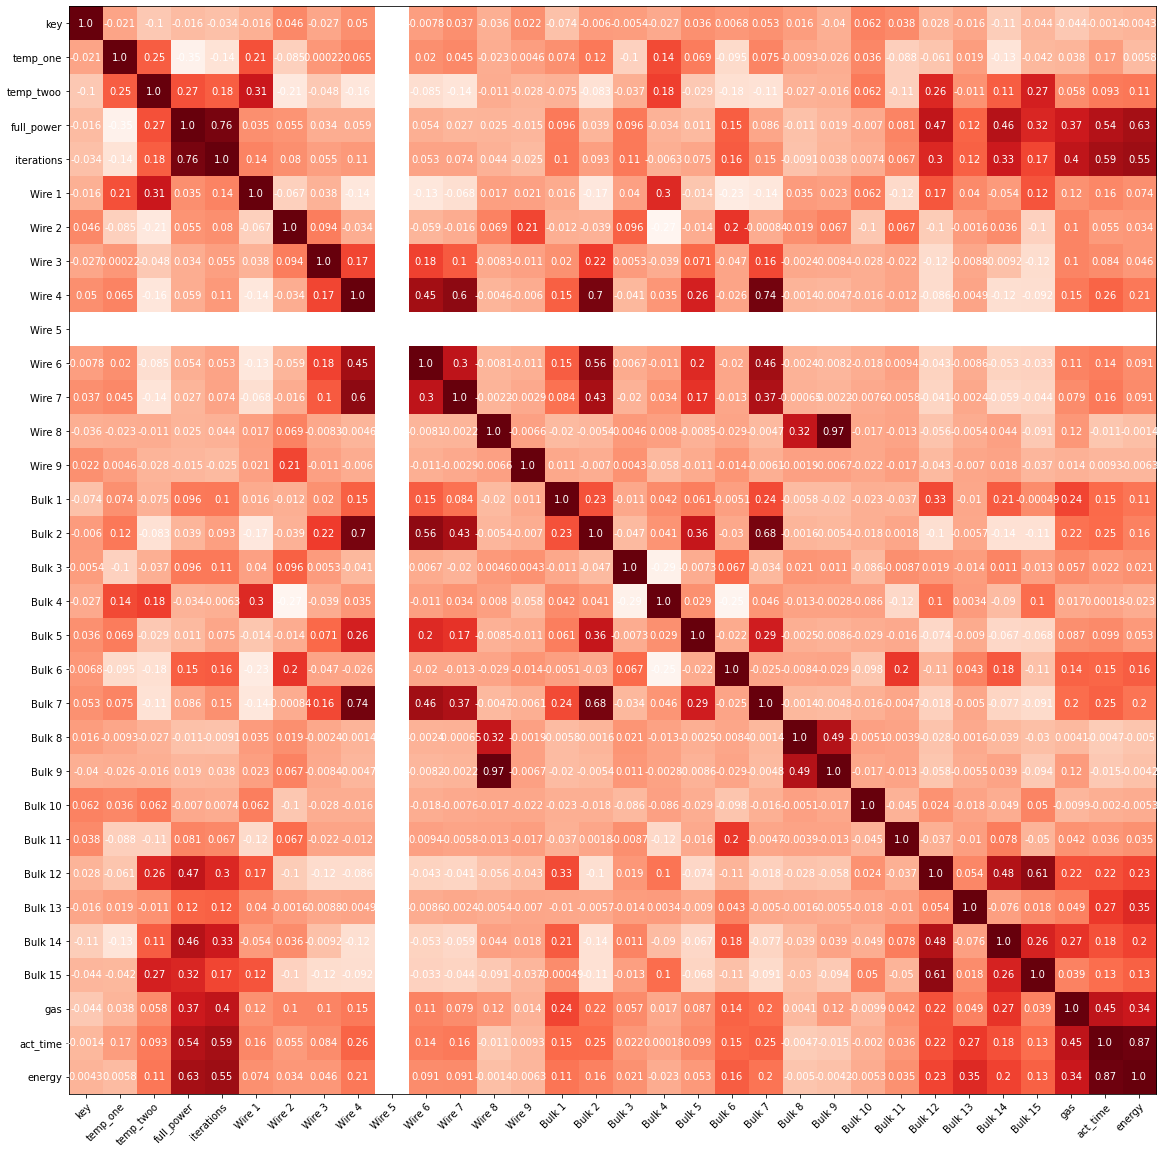

In [52]:
df_new_corr = df_new.copy()
corr_heatmap_data = df_new_corr.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(corr_heatmap_data.index)))
ax.set_yticks(np.arange(len(corr_heatmap_data.index)))

ax.set_xticklabels(corr_heatmap_data.index)
ax.set_yticklabels(corr_heatmap_data.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_data.values

for i in range(len(corr_heatmap_data.index)):
    for j in range(len(corr_heatmap_data.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(corr_heatmap_data.corr(), cmap='Reds')

По хидмепу видна сильная зависимость у bulk 9 и Wire 8, а также полностью отстутсвующие значения wire 5. удалю эти столбцы.

In [53]:
df_new = df_new.drop(columns = ['Bulk 9', 'Wire 5', 'Wire 8'], axis = 1)
df_new

,key,temp_one,temp_twoo,full_power,iterations,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,...,Bulk 8,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,act_time,energy
0,1,1571.0,1613.0,5.826395,5.0,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,861,5016.526038
1,2,1581.0,1602.0,3.649216,4.0,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1305,4762.227395
2,3,1596.0,1599.0,2.989534,5.0,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1300,3886.394411
3,4,1601.0,1625.0,3.814962,4.0,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,388,1480.205402
4,5,1576.0,1602.0,4.035758,4.0,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,762,3075.247462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,2495,1570.0,1591.0,3.986869,4.0,89.150879,0.00000,0.0,0.0,0.0,...,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,1137,4533.069488
2324,2496,1554.0,1591.0,5.057033,6.0,114.179527,0.00000,0.0,0.0,0.0,...,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,1618,8182.279285
2325,2497,1571.0,1589.0,2.885017,3.0,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,717,2068.557064
2326,2498,1591.0,1594.0,4.143749,5.0,118.110717,0.00000,0.0,0.0,0.0,...,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657,1302,5395.160994


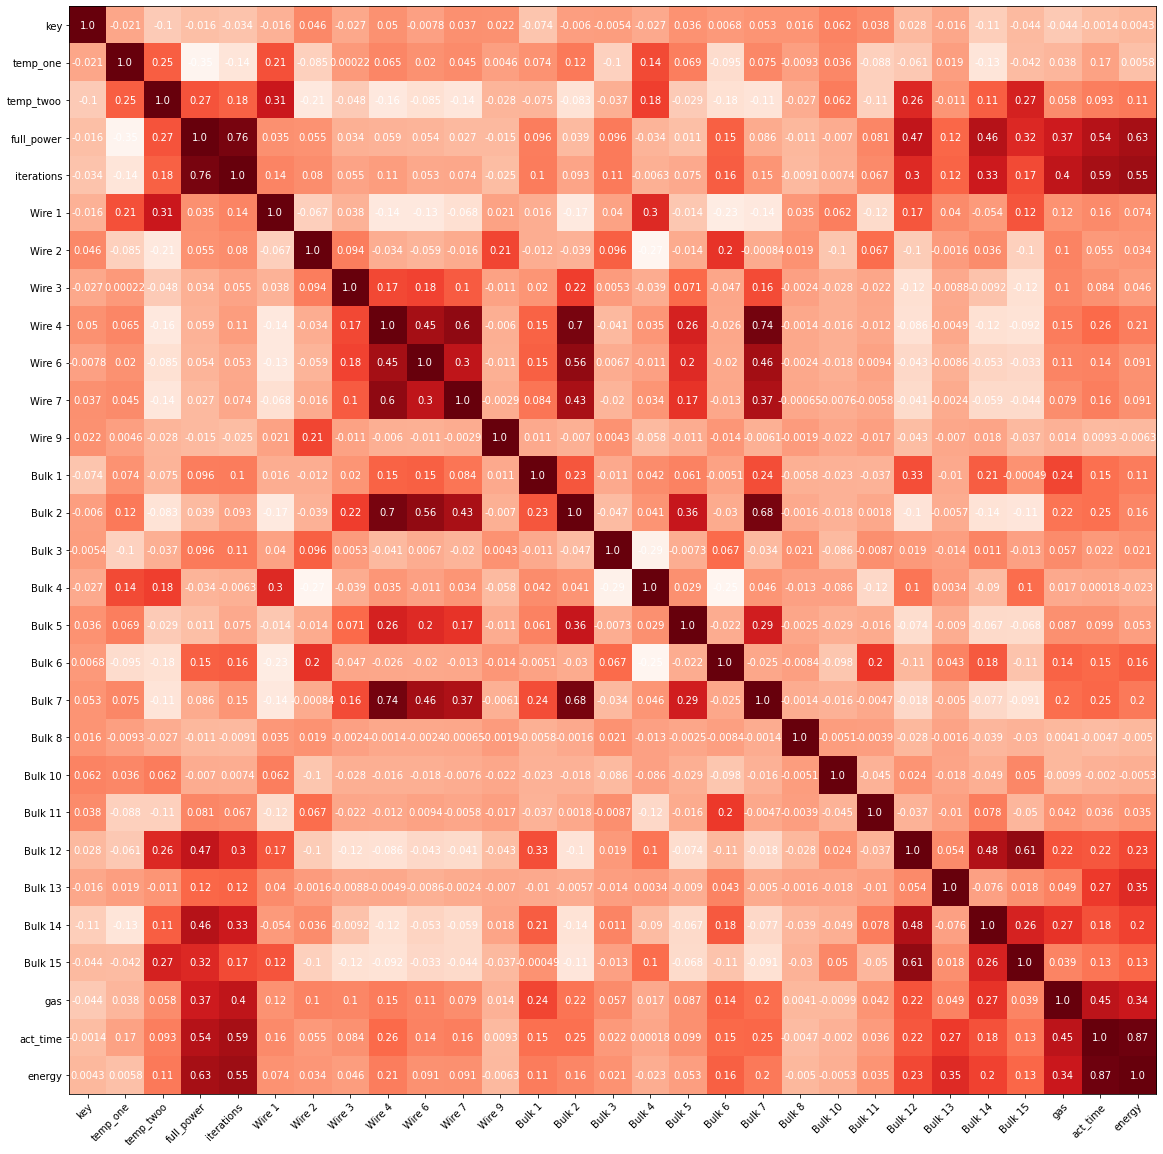

In [54]:
df_new_corr_o = df_new.copy()
corr_heatmap_data = df_new_corr_o.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(corr_heatmap_data.index)))
ax.set_yticks(np.arange(len(corr_heatmap_data.index)))

ax.set_xticklabels(corr_heatmap_data.index)
ax.set_yticklabels(corr_heatmap_data.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_data.values

for i in range(len(corr_heatmap_data.index)):
    for j in range(len(corr_heatmap_data.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(corr_heatmap_data.corr(), cmap='Reds')

Теперь таблица точно готова к моделированию.

Поделю данные на выборки.

In [55]:
x = df_new.drop(['temp_twoo', 'key'], axis=1)
y = df_new['temp_twoo']

In [56]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False, random_state=29082022)

In [57]:
(len(x_train) / len(x)*100, len(x_test) / len(x)*100, len(y_train) / len(y)*100, len(y_test) / len(y)*100)

(79.97382198952879, 20.026178010471206, 79.97382198952879, 20.026178010471206)

Выборки составлены. Обучать буду линейную регрессию, случайный лес, градиентный бустинг и кэтбустинг.

### Линейная регрессия

In [58]:
%%time
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid_lr = GridSearchCV(LinearRegression(), parameters, cv=5, scoring='neg_mean_absolute_error')
grid_lr.fit(x_train, y_train)
params = grid_lr.best_params_
cv_MAE_LR = abs(grid_lr.best_score_)
print('MAE на кросс-валидации: ', cv_MAE_LR)


MAE на кросс-валидации:  6.375190250212137
CPU times: user 1.17 s, sys: 1.86 s, total: 3.03 s
Wall time: 3.02 s


Слишком большое МАЕ, линейная регрессия не подходит в качестве конечной модели

### Случайный лес

In [59]:
random_params = {'n_estimators': [x for x in range(100, 500, 100)], 
               'max_depth': [x for x in range(1, 11, 2)]}

In [60]:
%%time
grid_rfr = GridSearchCV(RandomForestRegressor(random_state=29082022), 
                        random_params, refit=False, cv=5, scoring='neg_mean_absolute_error') 
grid_rfr.fit(x_train, y_train)
best_param = grid_rfr.best_params_
cv_MAE_RFR = abs(grid_rfr.best_score_)
print('MAE на кросс-валидации: ', cv_MAE_RFR)
print('Лучшие параметры леса: ', best_param)


MAE на кросс-валидации:  6.054609828507366
Лучшие параметры леса:  {'max_depth': 9, 'n_estimators': 300}
CPU times: user 1min 41s, sys: 381 ms, total: 1min 41s
Wall time: 1min 41s


Чуть лучше, чем линейная регрессия, но тоже мало

### Градиентный бустинг

In [61]:
lgbm_params = [{'num_leaves':[x for x in range(10, 31, 2)], 
                'learning_rate':[x/100 for x in range(1, 11, 2)]}]

In [62]:
%%time
grid_lgbm = GridSearchCV(lgb.LGBMRegressor(random_state=29082022), 
                    lgbm_params, cv=5, scoring='neg_mean_absolute_error', refit=False) 
grid_lgbm.fit(x_train, y_train)
best_param = grid_lgbm.best_params_
cv_MAE_LGBMR = abs(grid_lgbm.best_score_)
print('MAE на кросс-валидации: ', cv_MAE_LGBMR)
print('Лучшие параметры : ', best_param)



MAE на кросс-валидации:  5.800523076858885
Лучшие параметры :  {'learning_rate': 0.07, 'num_leaves': 18}
CPU times: user 7min 27s, sys: 3.46 s, total: 7min 31s
Wall time: 7min 35s


### Кэтбустинг

In [63]:
%%time
cbr = CatBoostRegressor(verbose=False, random_state=29082022)

cv_MAE_CBR = (cross_val_score(cbr, 
                             x_train, 
                             y_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of CatBoostRegressor =', cv_MAE_CBR)

Mean MAE from CV of CatBoostRegressor = 5.777218939768998
CPU times: user 14.2 s, sys: 522 ms, total: 14.8 s
Wall time: 18.2 s


In [64]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'LGBMRegressor',
         'CatBoostRegressor'
         ]
data = {'MAE на CV':[cv_MAE_LR,
                     cv_MAE_RFR,
                     cv_MAE_LGBMR,
                     cv_MAE_CBR
                     ]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,MAE на CV
LinearRegression,6.375190
RandomForestRegressor,6.054610
LGBMRegressor,5.800523
CatBoostRegressor,5.777219


Кэтбустинг и градиентый бустин показали практически одинаково хорошие результаты, но в качестве итоговой модели выберу всеже кэтбустинг, как минимум потому что она быстрее.

### Тестирование итоговой модели

In [65]:
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=29082022).fit(x_train, 
                                        y_train).get_all_params()


In [66]:
%%time

model_cat = CatBoostRegressor(verbose=False)
model_cat.set_params(**best_params_CBR)
model_cat.fit(x_train, y_train)
target_predict = model_cat.predict(x_test)
test_MAE_CBR = mean_absolute_error(target_predict, y_test)
print('MAE on test of CatBoostRegressor =', test_MAE_CBR)

MAE on test of CatBoostRegressor = 5.676514625900942
CPU times: user 3.02 s, sys: 164 ms, total: 3.19 s
Wall time: 4.18 s


МАЕ итоговой модели на тестовой выбрке = 5.67

### График важности факторов для моделирования

In [67]:
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=x_test.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='График важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

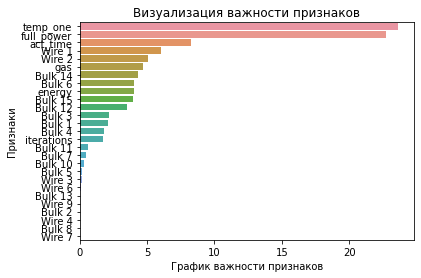

In [68]:
chart_feature_imp(model_cat)

# Отчёт о проделанной работе

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Для решения данной задачи предстояло предсказать конечную температуру стали. В качестве финального моделирования выступила CatBoostRegressor с метрикой качества предсказывания МАЕ = 5.7. А теперь по подробнее о том, как получился именно этот результат.
    
Были выданы исходные данные, содержащие в себе:
    
- `data_arc.csv` — данные об электродах;
    
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
    
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
    
- `data_gas.csv` — данные о продувке сплава газом;
    
- `data_temp.csv` — результаты измерения температуры;
    
- `data_wire.csv` — данные о проволочных материалах (объём);
    
- `data_wire_time.csv` — данные о проволочных материалах (время).
    
После беглого просмотра выданных данных, было принято решение исключить таблицы `data_bulk_time.csv` и `data_wire_time.csv` за их неинформативность. Далее была проведена предобработкаи и анализ данных, в результате:
    
- в таблице `data_arc.csv` в столбцах 'Начало нагрева дугой' и 'Конец нагрева дугой' были заменены типы данных с object на datetime(так как упомянутые выше столбцы содержали в себе даты). Также после проверки столбцов на выбросы, в столбце 'Реактивная мощность' было обнаружено единственное значение меньше 0(Хоть реактивная и может принимать отицательные значения, но в данном случае это единичный) и было исключено. Для борьбы с мультиколлинеарными значениями в моделировании не могли использовать активную и реактивную мощность так как эти значения имели достаточно большую зависимость друг от друга, в следствии чего была вычеслена полная мощность(сумма квадратов активной и реактивной мощностей). В этой же таблице с помощью группировки по значениям ключа были вычислены количество итераций, что привело к сокращению строк с 14872 до 3213(именно столько было уникальных партий стали).

- в таблице `data_bulk.csv` содержались данные о подаче сыпучих материалов. В таблице присутсвовало достаточно большое колличество пропусков, но данные пропуски свидетельствовали только о не подаче сыпучих веществ на каком то из этапов плавки стали, следовательно, эти пропуски были заменены на 0(чем в принципе они и являлись). Также проверив на мультиколлинеарность были удалены столбцы Bulk 5, Bulk 9. 

- в таблице `data_gas.csv`не имелось ни пропусков ни дубликатов, данные по гистограмме были распределены нормально, со смещением влево.

- в таблице `data_temp.csv` были обнаружены пропуски в столбце температуры, эти пропуски было невозможно ни коем образом восполнить, поэтому партии с пропусками в температуре бвли удалены. Также был заменен тип данных в столбце с временем измерения температуры. В этом столбце содержался основной признак - температура начала и конца нагрева. Эти признаки были вычислены путем составления по столбцу с временем самого первого и сасого последнего измерения. 

- в таблице `data_wire.csv` имелось большое количество пропусков, свидетельствующих о не подаче проволочных материалов. Данные пропуски также как и с сыпучими материалами, было принято решение заменить на 0. По результату проверки на мультиколлинеарность столбцы Wire 5 и 8 были удалены.

Последним этапом подготовки данных к моделированию был этап совмещения всех таблиц в одну с помощью метода merge путем соединения inner. Далее данные были поделены на обучающие и тестировачные выборки, а также на искомое значение и фичи.

Моделирование производилось на тренировочной выборке с помощью подбора гиперпараметров методом гридов на моделях LinearRegression(МАЕ = 6.37), RandomForestRegressor(МАЕ = 6.05), LGBMRegressor(МАЕ = 5.8), CatBoostRegressor(МАЕ = 5.7). В качестве итоговой модели была выбрана  CatBoostRegressor её результат на тестировачной выборке составил МАЕ = 5.67. 

По результату дополнительного исследования важности признаков для итоговой модели можно сделать вывод, что наиболее важными параметрами в технологическом процессе для конечной температуры являются начальная температура плавления, полная мощность и время нагрева.

В конечном счете, после проведенного исследования, можно сделать вывод что управляя начальной температурой, полной мощностью и временем нагрева, можно сократить расходы, управляя этими наиболее значимыми параметрами. И этот отчёт служит начальным этапом для проведения комплекса мероприятий и исследований в дальнейшем, для более точного и полного решения поставленной задачи.



